<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [GTSRB3] - Training monitoring
<!-- DESC --> Episode 3 : Monitoring, analysis and check points during a training session
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
  - **Understand** what happens during the **training** process
  - Implement **monitoring**, **backup** and **recovery** solutions
  
The German Traffic Sign Recognition Benchmark (GTSRB) is a dataset with more than 50,000 photos of road signs from about 40 classes.  
The final aim is to recognise them !  
Description is available there : http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset

## What we're going to do :

 - Monitoring and understanding our model training 
 - Add recovery points
 - Analyze the results 
 - Restore and run recovery points

## Step 1 - Import and init
### 1.1 - Python stuffs

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard

import numpy as np
import h5py

from sklearn.metrics import confusion_matrix
from skimage import io, transform, color

import matplotlib.pyplot as plt
import os, sys, time, random

from importlib import reload

sys.path.append('..')
import fidle.pwk as pwk

run_dir = './run/GTSRB3.001'
datasets_dir = pwk.init('GTSRB3', run_dir)

<br>**FIDLE 2020 - Practical Work Module**

Version              : 0.6.1 DEV
Notebook id          : GTSRB3
Run time             : Thursday 7 January 2021, 12:15:52
TensorFlow version   : 2.2.0
Keras version        : 2.3.0-tf
Datasets dir         : /home/pjluc/datasets/fidle
Run dir              : ./run/GTSRB3.001
Update keras cache   : False
Save figs            : True
Path figs            : ./run/GTSRB3.001/figs


### 1.2 - Parameters
`scale` is the proportion of the dataset that will be used during the training. (1 mean 100%)  
A 24x24 dataset, with 5 epochs and a scale of 1, need  3'30 on a CPU laptop.

In [2]:
dataset_name = 'set-24x24-L'
batch_size   = 64
epochs       = 5
scale        = 1

Override parameters (batch mode) - Just forget this cell

In [3]:
pwk.override('dataset_name', 'batch_size', 'epochs', 'scale')

## Step 2 - Load dataset
Dataset is one of the saved dataset: RGB25, RGB35, L25, L35, etc.  
First of all, we're going to use a smart dataset : **set-24x24-L**  
(with a GPU, it only takes 35'' compared to more than 5' with a CPU !)

In [4]:
def read_dataset(dataset_dir, name):
    '''Reads h5 dataset from dataset_dir
    Args:
        dataset_dir : datasets dir
        name        : dataset name, without .h5
    Returns:    x_train,y_train,x_test,y_test data'''
    # ---- Read dataset
    pwk.chrono_start()
    filename=f'{dataset_dir}/GTSRB/enhanced/{name}.h5'
    with  h5py.File(filename,'r') as f:
        x_train = f['x_train'][:]
        y_train = f['y_train'][:]
        x_test  = f['x_test'][:]
        y_test  = f['y_test'][:]
        x_meta  = f['x_meta'][:]
        y_meta  = f['y_meta'][:]

    # ---- Shuffle
    x_train,y_train=pwk.shuffle_np_dataset(x_train,y_train)

    # ---- done
    duration = pwk.chrono_stop(hdelay=True)
    size     = pwk.hsize(os.path.getsize(filename))
    print(f'Dataset "{name}" is loaded and shuffled. ({size} in {duration})')
    return x_train,y_train, x_test,y_test, x_meta,y_meta

# ---- Read dataset
#
x_train,y_train, x_test,y_test, x_meta,y_meta = read_dataset(datasets_dir, dataset_name)

# ---- Rescale 
#
x_train,y_train,x_test,y_test = pwk.rescale_dataset(x_train,y_train,x_test,y_test, scale=scale)

Dataset "set-24x24-L" is loaded and shuffled. (228.8 Mo in 00:00:00 099ms)


## Step 3 - Have a look to the dataset
Note: Data must be reshape for matplotlib

x_train :  (39209, 24, 24, 1)
y_train :  (39209,)
x_test  :  (12630, 24, 24, 1)
y_test  :  (12630,)


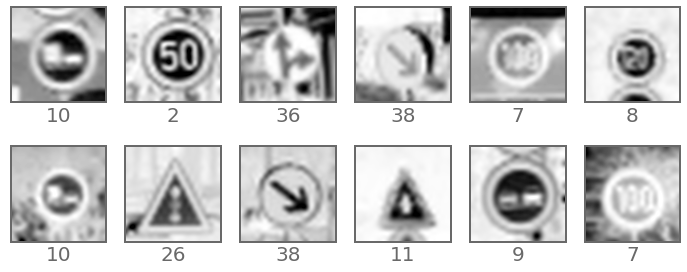

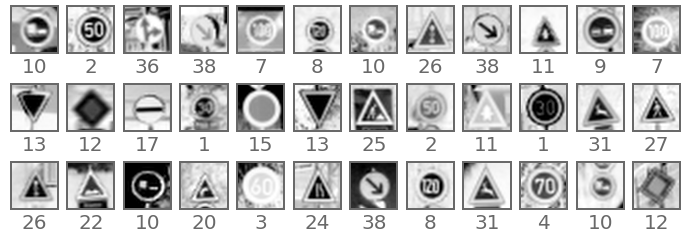

In [5]:
print("x_train : ", x_train.shape)
print("y_train : ", y_train.shape)
print("x_test  : ", x_test.shape)
print("y_test  : ", y_test.shape)

pwk.plot_images(x_train, y_train, range(12), columns=6,  x_size=2, y_size=2, save_as='01-dataset-medium')
pwk.plot_images(x_train, y_train, range(36), columns=12, x_size=1, y_size=1, save_as='02-dataset-small')

## Step 4 - Create model
We will now build a model and train it...

Some models... 

In [6]:
# A basic model
#
def get_model_v1(lx,ly,lz):
    
    model = keras.models.Sequential()
    
    model.add( keras.layers.Conv2D(96, (3,3), activation='relu', input_shape=(lx,ly,lz)))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(192, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Flatten()) 
    model.add( keras.layers.Dense(1500, activation='relu'))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Dense(43, activation='softmax'))
    return model


## Step 5 - Prepare callbacks  
We will add 2 callbacks :  

**TensorBoard**  
Training logs, which can be visualised using [Tensorboard tool](https://www.tensorflow.org/tensorboard).  

**Model backup**  
 It is possible to save the model each xx epoch or at each improvement.  
 The model can be saved completely or partially (weight).  
 For full format, we can use HDF5 format.

In [7]:
pwk.mkdir(run_dir + '/models')
pwk.mkdir(run_dir + '/logs')

# ---- Callback tensorboard
log_dir = run_dir + "/logs/tb_" + pwk.tag_now()
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# ---- Callback ModelCheckpoint - Save best model
save_dir = run_dir + "/models/best-model.h5"
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, monitor='accuracy', save_best_only=True)

# ---- Callback ModelCheckpoint - Save model each epochs
save_dir = run_dir + "/models/model-{epoch:04d}.h5"
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0)

print(f'To run tensorboard, use :  --logdir {run_dir}/logs')

To run tensorboard, use :  --logdir ./run/GTSRB3.001/logs


## Step 6 - Train the model
**Get the shape of my data :**

In [8]:
(n,lx,ly,lz) = x_train.shape
print("Images of the dataset have this folowing shape : ",(lx,ly,lz))

Images of the dataset have this folowing shape :  (24, 24, 1)


**Get and compile a model, with the data shape :**

In [9]:
model = get_model_v1(lx,ly,lz)

# model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

**Train it :**  
Note: The training curve is visible in real time with Tensorboard (see step  5)

In [10]:
pwk.chrono_start()

# ---- Shuffle train data
x_train,y_train=pwk.shuffle_np_dataset(x_train,y_train)

# ---- Train
# Note: To be faster in our example, we can take only 2000 values
#
history = model.fit(  x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=(x_test, y_test),
                      callbacks=[tensorboard_callback, bestmodel_callback, savemodel_callback] )

model.save(f'{run_dir}/models/last-model.h5')

pwk.chrono_show()

Epoch 1/5
613/613 [==============================] - 40s 65ms/step - loss: 1.1016 - accuracy: 0.6954 - val_loss: 0.3853 - val_accuracy: 0.9112
Epoch 2/5
613/613 [==============================] - 42s 68ms/step - loss: 0.1944 - accuracy: 0.9448 - val_loss: 0.2914 - val_accuracy: 0.9287
Epoch 3/5
613/613 [==============================] - 43s 70ms/step - loss: 0.1088 - accuracy: 0.9685 - val_loss: 0.2525 - val_accuracy: 0.9417
Epoch 4/5
613/613 [==============================] - 44s 72ms/step - loss: 0.0757 - accuracy: 0.9776 - val_loss: 0.2221 - val_accuracy: 0.9414
Epoch 5/5
613/613 [==============================] - 45s 73ms/step - loss: 0.0579 - accuracy: 0.9832 - val_loss: 0.2389 - val_accuracy: 0.9423

Duration :  00:03:35 503ms


**Evaluate it :**

In [11]:
max_val_accuracy = max(history.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

Max validation accuracy is : 0.9423


In [12]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 0.2389
Test accuracy  : 0.9423


## Step 7 - History
The return of model.fit() returns us the learning history

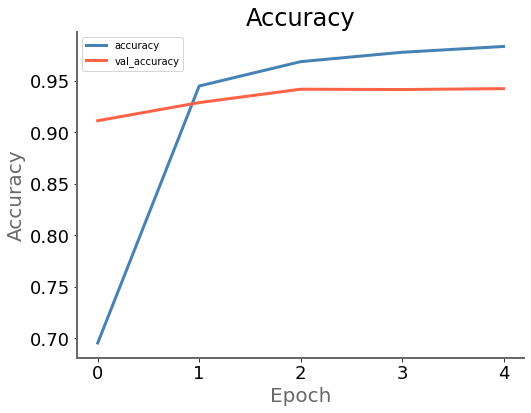

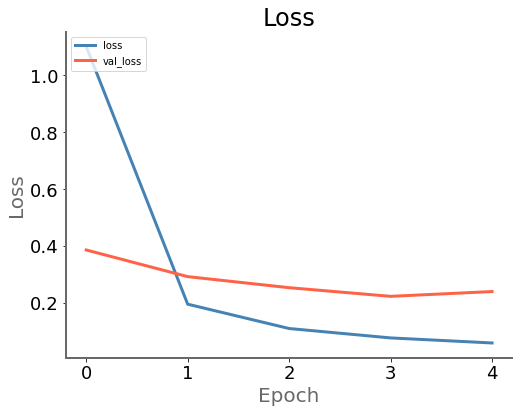

In [13]:
pwk.plot_history(history, save_as='03-history')

## Step 8 - Evaluation and confusion

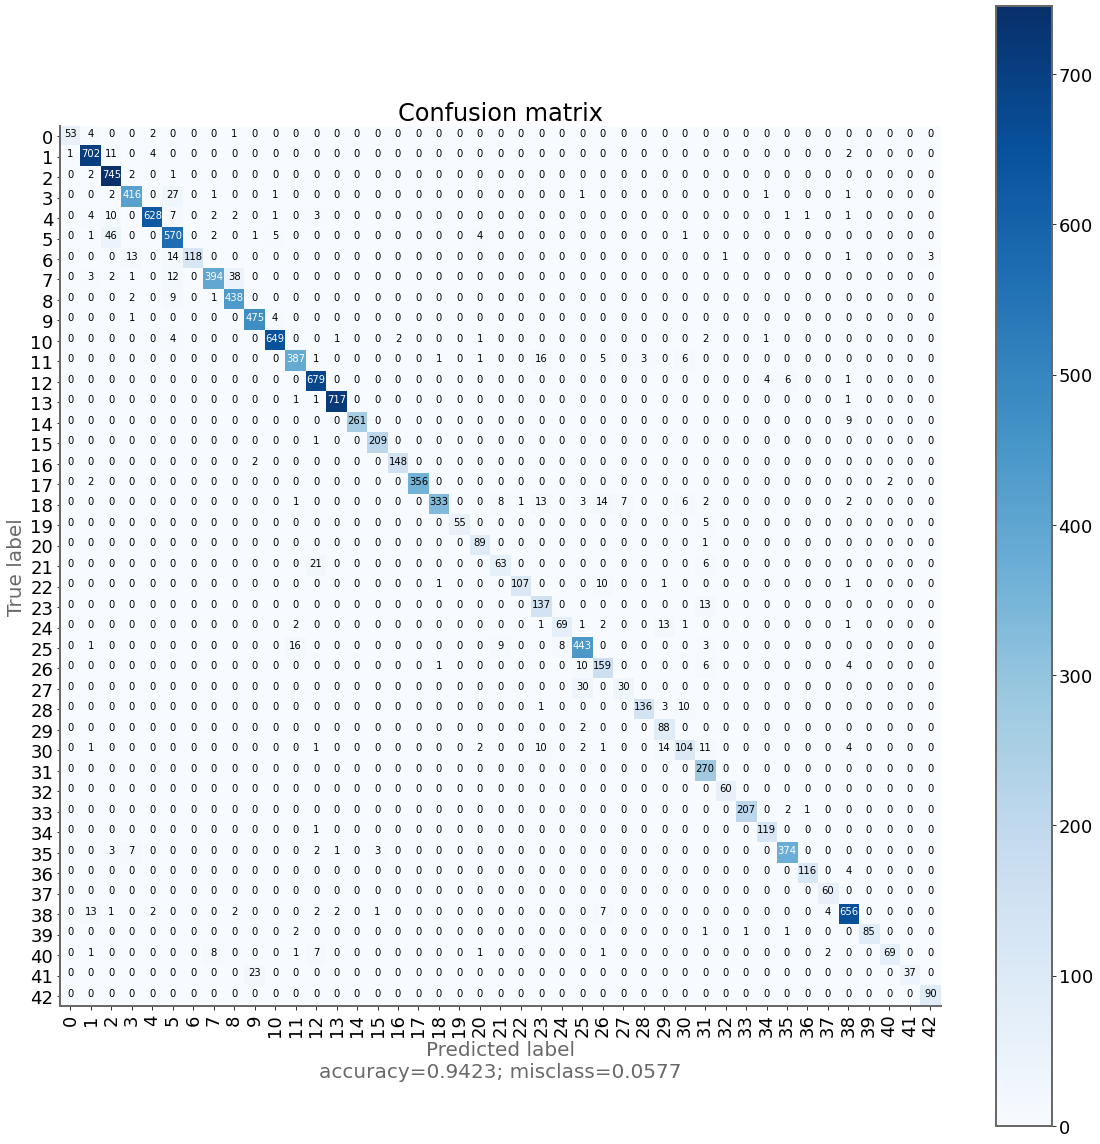

In [14]:
y_sigmoid = model.predict(x_test)
y_pred    = np.argmax(y_sigmoid, axis=-1)

pwk.plot_confusion_matrix(y_test,y_pred,range(43), figsize=(16, 16),normalize=False, save_as='04-confusion-matrix')

## Step 9 - Restore and evaluate
### 9.1 - List saved models :

In [15]:
!find "$run_dir"/models/

./run/GTSRB3.001/models/
./run/GTSRB3.001/models/model-0003.h5
./run/GTSRB3.001/models/model-0001.h5
./run/GTSRB3.001/models/last-model.h5
./run/GTSRB3.001/models/model-0004.h5
./run/GTSRB3.001/models/model-0002.h5
./run/GTSRB3.001/models/model-0005.h5
./run/GTSRB3.001/models/best-model.h5


### 9.2 - Restore a model :

In [16]:
loaded_model = tf.keras.models.load_model(f'{run_dir}/models/best-model.h5')
# loaded_model.summary()
print("Loaded.")

Loaded.


### 9.3 - Evaluate it :

In [17]:
score = loaded_model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 0.2389
Test accuracy  : 0.9423


### 9.4 - Make a prediction :


Output layer from model is (x100) :

[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 100.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.]]

Graphically :



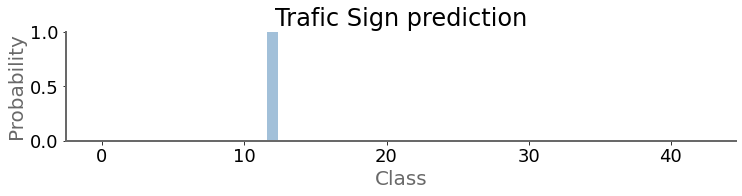


The image :               Prediction :            Real stuff:


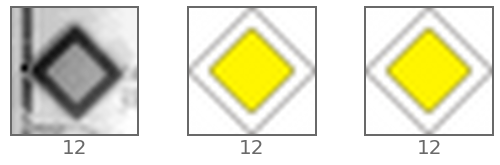

YEEES ! that's right!


In [18]:
# ---- Get a random image
#
i   = random.randint(1,len(x_test))
x,y = x_test[i], y_test[i]

# ---- Do prediction
#
predictions = loaded_model.predict( np.array([x]) )

# ---- A prediction is just the output layer
#
print("\nOutput layer from model is (x100) :\n")
with np.printoptions(precision=2, suppress=True, linewidth=95):
    print(predictions*100)

# ---- Graphic visualisation
#
print("\nGraphically :\n")
plt.figure(figsize=(12,2))
plt.bar(range(43), predictions[0], align='center', alpha=0.5)
plt.ylabel('Probability')
plt.ylim((0,1))
plt.xlabel('Class')
plt.title('Trafic Sign prediction')
pwk.save_fig('05-prediction-proba')
plt.show()

# ---- Predict class
#
p = np.argmax(predictions)

# ---- Show result
#
print("\nThe image :               Prediction :            Real stuff:")
pwk.plot_images([x,x_meta[p], x_meta[y]], [p,p,y], range(3),  columns=3,  x_size=3, y_size=2, save_as='06-prediction-images')

if p==y:
    print("YEEES ! that's right!")
else:
    print("oups, that's wrong ;-(")

In [19]:
pwk.end()

End time is : Thursday 7 January 2021, 12:20:01
Duration is : 00:04:09 711ms
This notebook ends here


<div class="todo">
     What you can do:
    <ul>
        <li>Limit model saving: 1 save every 5 epochs </li>
        <li>Use a subset of the dataset</li>
        <li>Try different datasets</li>
        <li>Some exotic signs are waiting to be recognized in dataset_dir/extra !</li>
        <li>Test different hyperparameters (epochs, batch size, optimization, etc.)</li>
    </ul>
    
</div>

---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>